In [1]:
import numpy as np
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Input, Conv1D, Conv2D, Flatten, MaxPooling2D, UpSampling2D
from keras import regularizers
from keras.utils import np_utils
from keras.utils import plot_model
from keras.optimizers import Adam
from PIL import Image
import os
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
import matplotlib.image as img
from sklearn.metrics import mean_squared_error
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger

Using TensorFlow backend.


In [2]:
import numpy as np
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Input, Conv1D, Conv2D, Flatten, MaxPooling2D, UpSampling2D
from keras import regularizers
from keras.utils import np_utils
from keras.utils import plot_model
from keras.optimizers import Adam
from PIL import Image
import pandas as pd 
import os
import csv
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
import matplotlib.image as img
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger

In [3]:
cd CBIR

/Users/osamaqureshi/Documents/LUMS/DIP/Assignments/HW4/CBIR


In [4]:
# load images

size = 1228800
length = 1500
names = []
images = []
for i, filename in enumerate(os.listdir(os.getcwd())):
    if i == 1500:
        break
    if filename != '.DS_Store':
        im = img.imread(filename)
        im = np.resize(im,(400,400,3))
        images.append(im)
        names.append(filename) 
images = np.array(images)
print type(images), np.shape(images)

<type 'numpy.ndarray'> (1500, 400, 400, 3)


In [5]:
print type(images[0]), np.shape(images[0])

<type 'numpy.ndarray'> (400, 400, 3)


In [6]:
# Encoder

input_img = Input(shape = (400,400,3))
# input = Reshape((400,400,3), input_shape=(None,None,3)       
model1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_img)
model2 = MaxPooling2D(pool_size=(2, 2), padding='same')(model1)
model3 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(model2)
model4 = MaxPooling2D(pool_size=(2, 2), padding='same')(model3)
model3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(model2)
model4 = MaxPooling2D(pool_size=(2, 2), padding='same')(model3)

encoded = Dense(4096, activation='relu')(model4)

In [7]:
# Decoder

model5 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(encoded)
model6 = UpSampling2D((2, 2))(model5)
model7 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(model6)
model8 = UpSampling2D((2, 2))(model7)

decoded = Conv2D(3, kernel_size=(3,3), activation='sigmoid', padding='same')(model8)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
# Model train

autoencoder.fit(images[1:1000,:,:,:], images[1:1000,:,:,:],
          batch_size=128, 
          epochs=10,
          validation_data=(images[1000:1400,:,:,:], images[1000:1400,:,:,:]))

# Save model 
autoencoder.save('homework4.h')

# autoencoder.fit(images[1:1000,:,:,:], images[1:1000,:,:,:],
#                 epochs=10,
#                 batch_size=128,
#                 shuffle=True,
#                 callbacks = [checkpoint],
#                 validation_data=(images[1000:1400,:,:,:], images[1000:1400,:,:,:]))

Train on 999 samples, validate on 400 samples
Epoch 1/10


In [121]:
# generate database of feature vectors

encoder = Model(input_img, encoded)
database = encoder.predict(images)
print np.shape(database)

(12062, 50, 50, 8)


In [ ]:
for i in range(len(database)):
    mse.append(mean_squared_error(database[i,:,:,:].flatten(), x))

In [130]:
def test_Im(im, database):
    x = encoder.predict(im)
    x = x.flatten()
    
    mse = []
    for i in range(len(database)):
        mse.append([mean_squared_error(database[i,:,:,:].flatten(), x), i])
    mse = np.array(mse)
    mse = mse[mse[:,0].argsort()]
    
    return mse[0:10,1]

(1, 400, 400, 3) [11000  1837  8487  9743   813 10538  2374  2988  6850  1385]


SyntaxError: 'break' outside loop (<ipython-input-152-8c40081c4329>, line 9)

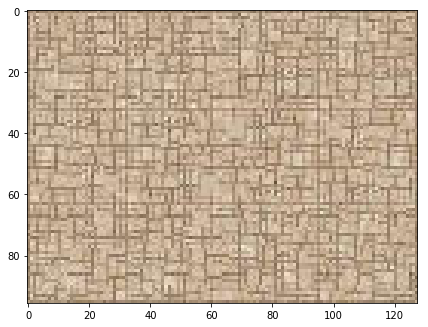

In [152]:
s = images[11000:11001,:,:,:]
x = test_Im(s,database)
x = x.astype(int)
print np.shape(s),x
plt.imshow(s[0,:,:,:])
for i in range(10):
    im = img.imread(names[x[i]])
    plt.imshow(im)
break

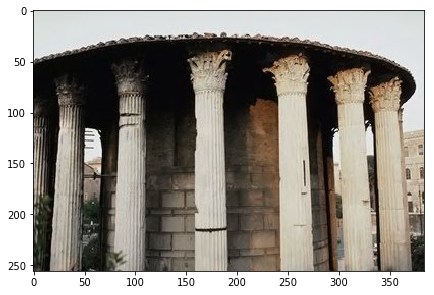

In [143]:
im = img.imread(names[x[0]])
plt.imshow(im)

In [72]:
y = encoder.predict(x)
print np.shape(y)

z = database[0,:,:,:].flatten()
mse = mean_squared_error(z.flatten(), y.flatten())
print(mse)

(1, 50, 50, 8)
9776.77


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Dropout, Reshape, Permute, Activation, \
    Input, merge
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
import numpy as np
from scipy.misc import imread, imresize, imsave

from convnetskeras.customlayers import convolution2Dgroup, crosschannelnormalization, \
    splittensor, Softmax4D
from convnetskeras.imagenet_tool import synset_to_id, id_to_synset,synset_to_dfs_ids

In [ ]:
def convnet(weights_path=None, heatmap=False, trainable=None):
    """
    Returns a keras model for a CNN.
    BEWARE !! : Since the different convnets have been trained in different settings, they don't take
    data of the same shape. You should change the arguments of preprocess_image_batch for each CNN :
    * For AlexNet, the data are of shape (227,227), and the colors in the RGB order (default)
    * For VGG16 and VGG19, the data are of shape (224,224), and the colors in the BGR order
    It can also be used to look at the hidden layers of the model.
    It can be used that way :
    >>> im = preprocess_image_batch(['cat.jpg'])
    >>> # Test pretrained model
    >>> model = convnet('vgg_16', 'weights/vgg16_weights.h5')
    >>> sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    >>> model.compile(optimizer=sgd, loss='categorical_crossentropy')
    >>> out = model.predict(im)
    Parameters
    --------------
    network: str
        The type of network chosen. For the moment, can be 'vgg_16' or 'vgg_19'
    weights_path: str
        Location of the pre-trained model. If not given, the model will be trained
    heatmap: bool
        Says wether the fully connected layers are transformed into Convolution2D layers,
        to produce a heatmap instead of a
    Returns
    ---------------
    model:
        The keras model for this convnet
    output_dict:
        Dict of feature layers, asked for in output_layers.
    """


    # Select the network
    convnet_init = AlexNet
    convnet = convnet_init(weights_path, heatmap=False)

    if not heatmap:
        return convnet
    else:
        convnet_heatmap = convnet_init(heatmap=True)

        for layer in convnet_heatmap.layers:
            if layer.name.startswith("conv"):
                orig_layer = convnet.get_layer(layer.name)
                layer.set_weights(orig_layer.get_weights())
            elif layer.name.startswith("dense"):
                orig_layer = convnet.get_layer(layer.name)
                W,b = orig_layer.get_weights()
                n_filter,previous_filter,ax1,ax2 = layer.get_weights()[0].shape
                new_W = W.reshape((previous_filter,ax1,ax2,n_filter))
                new_W = new_W.transpose((3,0,1,2))
                new_W = new_W[:,:,::-1,::-1]
                layer.set_weights([new_W,b])
        return convnet_heatmap

    return model

In [ ]:
def AlexNet(weights_path=None):
    if heatmap:
        inputs = Input(shape=(3,None,None))
    else:
        inputs = Input(shape=(3,227,227))

    conv_1 = Convolution2D(96, 11, 11,subsample=(4,4),activation='relu',
                           name='conv_1')(inputs)

    conv_2 = MaxPooling2D((3, 3), strides=(2,2))(conv_1)
    conv_2 = crosschannelnormalization(name="convpool_1")(conv_2)
    conv_2 = ZeroPadding2D((2,2))(conv_2)
    conv_2 = merge([
        Convolution2D(128,5,5,activation="relu",name='conv_2_'+str(i+1))(
            splittensor(ratio_split=2,id_split=i)(conv_2)
        ) for i in range(2)], mode='concat',concat_axis=1,name="conv_2")

    conv_3 = MaxPooling2D((3, 3), strides=(2, 2))(conv_2)
    conv_3 = crosschannelnormalization()(conv_3)
    conv_3 = ZeroPadding2D((1,1))(conv_3)
    conv_3 = Convolution2D(384,3,3,activation='relu',name='conv_3')(conv_3)

    conv_4 = ZeroPadding2D((1,1))(conv_3)
    conv_4 = merge([
        Convolution2D(192,3,3,activation="relu",name='conv_4_'+str(i+1))(
            splittensor(ratio_split=2,id_split=i)(conv_4)
        ) for i in range(2)], mode='concat',concat_axis=1,name="conv_4")

    conv_5 = ZeroPadding2D((1,1))(conv_4)
    conv_5 = merge([
        Convolution2D(128,3,3,activation="relu",name='conv_5_'+str(i+1))(
            splittensor(ratio_split=2,id_split=i)(conv_5)
        ) for i in range(2)], mode='concat',concat_axis=1,name="conv_5")

    dense_1 = MaxPooling2D((3, 3), strides=(2,2),name="convpool_5")(conv_5)

    
    dense_1 = Flatten(name="flatten")(dense_1)
    dense_1 = Dense(4096, activation='relu',name='dense_1')(dense_1)
    dense_2 = Dropout(0.5)(dense_1)
    dense_2 = Dense(4096, activation='relu',name='dense_2')(dense_2)
    dense_3 = Dropout(0.5)(dense_2)
    dense_3 = Dense(1000, activation='relu', name='dense_3')(dense_3)
    
#     prediction = Activation("softmax",name="softmax")(dense_3)

    model = Model(input=inputs, output=dense3)

    if weights_path:
        model.load_weights(weights_path)

    return model

In [ ]:
def preprocess_image_batch(image_paths, img_size=None, crop_size=None, color_mode="rgb", out=None):
    img_list = []

    for im_path in image_paths:
        img = imread(im_path, mode='RGB')
        if img_size:
            img = imresize(img,img_size)

        img = img.astype('float32')
        # We normalize the colors (in RGB space) with the empirical means on the training set
        img[:, :, 0] -= 123.68
        img[:, :, 1] -= 116.779
        img[:, :, 2] -= 103.939
        # We permute the colors to get them in the BGR order
        if color_mode=="bgr":
            img[:,:,[0,1,2]] = img[:,:,[2,1,0]]
        img = img.transpose((2, 0, 1))

        if crop_size:
            img = img[:,(img_size[0]-crop_size[0])//2:(img_size[0]+crop_size[0])//2
                      ,(img_size[1]-crop_size[1])//2:(img_size[1]+crop_size[1])//2]

        img_list.append(img)

    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        raise ValueError('when img_size and crop_size are None, images'
                ' in image_paths must have the same shapes.')

    if out is not None and hasattr(out, 'append'):
        out.append(img_batch)
    else:
        return img_batch